## Prior simulation checks

Need to do these

In [2]:
import numpyro
numpyro.util.set_host_device_count(4)

import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from jax.random import PRNGKey
from numpyro.infer import MCMC, NUTS, Predictive

import numpy as np
import pandas as pd
import seaborn as sns

import siuba as s
from siuba import _

from plotnine import *

from lib.models import *
from lib.helpers import *
from lib.simdata import make_sim_data_ptn_avg

# Averaged models

Averaged models use the same priors for both Bayesian sampler and PTN as I've parameterized them both by implicit $d$ parameters. These priors look nice.

In [3]:
def sample_prior(model, data, num_samples=1000):

    prior = Predictive(model, num_samples=num_samples)(
        jax.random.PRNGKey(2), data
    )

    return az.from_numpyro(
        prior = prior
    )

def make_dummy_data():
    params_ptn = {
    "d_base": {k: [.25,.35,.1][k] for k in range(0, 1)},
    "d_delta": {k: [.1, .05, .2][k] for k in range(0, 1)},
    "k": {k: [21, 17, 11][k] for k in range(0, 1)} # or e.g. k: [15 for k in ...]
    }

    sim_data = make_sim_data_ptn_avg(1, 1, params_ptn)
    sim_data["estimate"] = .5

    return(sim_data)

X_data, y_data = make_model_data(make_dummy_data())


/Users/derekpowell/Projects/Repositories/bayesian-sampler/lib/helpers.py:134: UserWarning: Explicitly requested dtype int requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


In [4]:
from scipy.special import expit

def model_ptn(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0]

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    d_base_pop = numpyro.sample("d_base_pop", dist.Normal(-1.0, 1.0))
    d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0, .5)) # bias toward lower values for non conj/disj trials
    d_base_sd = numpyro.sample("d_base_sd", dist.LogNormal(-1., 1.)) # was halfcauchy(1)
    d_delta_sd = numpyro.sample("d_delta_sd", dist.LogNormal(-1., 1.)) # approx uniform altogether we hope

    # subject-level parameters/priors
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base_r", dist.Normal(0, 1))
        d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, 1))

    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    d_lin = (d_base_pop +
             d_bases[subj]*d_base_sd +
             jnp.exp(d_delta_pop + d_delta_sd*d_deltas[subj])*conjdisj
            )  # exp() constrains d_delta to be positive

    d = sigmoid(d_lin)/2.0 # require this be in [0, .50]

    # deterministic sites
    numpyro.deterministic("d_subj", sigmoid(d_base_pop + d_bases*d_base_sd)/2.)
    numpyro.deterministic("d_prime_subj",
                          sigmoid(d_base_pop +
                                  d_bases*d_base_sd +
                                  jnp.exp(d_delta_pop + d_deltas*d_delta_sd)
                                 )/2.
                         )

    theta_ind = (subj*n_conds) + cond
    theta = thetas[theta_ind,:]

    p_ptn = prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d) #

    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)

    return yhat

In [5]:
prior_ptn = sample_prior(model_ptn, X_data)

/Users/derekpowell/anaconda3/envs/bsampler/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/Users/derekpowell/anaconda3/envs/bsampler/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='d_prime_subj', ylabel='Density'>

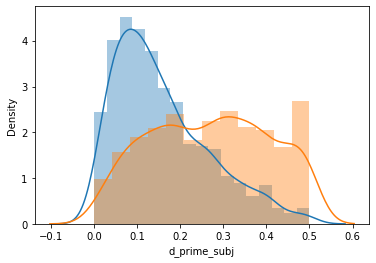

In [6]:
from scipy.special import expit

df_prior = prior_to_df_mlm(
    prior_ptn, 
    ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"],
    ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj"]
)

sns.distplot(df_prior.d_subj)
sns.distplot(df_prior.d_prime_subj)


This looks good. The Bayesian sampler version is just the same thing rescaled to fall $\in [0, 1/3]$.

# Bayesian sampler Trial-level model

The trial-level version is uniquely parameterized by $N, N', \beta$ for each participant.

Switching to a softplus transform rather than exp and sigmoid seems to be making things considerably nicer.

In [99]:
from jax.nn import softplus
from jax.scipy.special import expit
# import tensorflow_probability.substrates.jax as tfp

## # ------ helper functions 
def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


## rounding stuff
from jax import vmap

def spread_vec(x, step_size): # this works without static arguments
    base_steps = x.shape[0]
    x_split = jnp.split(x, base_steps)
    pad = jnp.zeros(step_size-1)
    probs = jnp.stack([jnp.concatenate((i,pad)) for i in x_split]).flatten()
    probs = probs[0:21]
    return probs/jnp.sum(probs)


def bs_dist(p, beta, N):
    return (p * N) / (N + 2 * beta) + beta / (N + 2 * beta)


def bs_dist_inv(x, beta, N):
    return (x - beta / (N + 2. * beta)) * (N + 2. * beta) / N


def bs_dist_cdf(N, beta, a, b, x):
    # where x is untransformed probability
    trans_x = bs_dist_inv(x, beta, N)

    res = jnp.where(
        jnp.logical_or( trans_x <= 0., trans_x >= 1.), 
        jnp.clip(trans_x, 0., 1.), 
        tfp.math.betainc(a, b, jnp.clip(trans_x, 1e-8, 1-1e-8))
    )

    return res


def f_bs(mu, N, beta, responses):
    
    a = mu*N
    b = (1.-mu)*N
    
    n_resps = (responses.shape[0]-1)
    step = int(20/n_resps)
    rnd_unit_scaled = 1/n_resps
    
    lower = jnp.clip((responses/n_resps) - rnd_unit_scaled/2., 1e-8, 1-1e-8)
    upper = jnp.clip((responses/n_resps) + rnd_unit_scaled/2., 1e-8, 1-1e-8)
    
    prob_resps = bs_dist_cdf(N, beta, a, b, upper) - bs_dist_cdf(N, beta, a, b, lower)
    prob_resps = (spread_vec(prob_resps, step) + 1e-30)
    prob_resps = (prob_resps)/jnp.sum(prob_resps)
    
    return(prob_resps)


bs_cat_probs = vmap(f_bs, (0, 0, 0, None))

responses_10 = jnp.linspace(0, 10, num=11)
responses_5 = jnp.linspace(0, 20, num=21)


def bs_complex_mlm_trial_level(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-1, 1)) # skewed after sigmoid
    beta_sd = numpyro.sample("beta_sd", dist.LogNormal(-1, 1))

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(10, 5)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0, 10)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.LogNormal(-.5, 1.6))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.LogNormal(-.5, 1.6))
    
    rnd_policy = numpyro.sample("rnd_policy", dist.Dirichlet(jnp.ones(3)))

    # subject-level parameters/priors <--- non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, 1))*beta_sd 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, 1))*N_delta_sd
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, 1))*N_prime_sd

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    # beta = expit(beta_pop + betas[subj])*10 # constrains beta to [0,10]
    
    beta = softplus(beta_pop + betas[subj])
    
    numpyro.deterministic("beta_subj", softplus(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + softplus(N_prime_pop + N_primes[subj]) + softplus(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_prime_subj", 1 + softplus(N_prime_pop + N_primes))
    numpyro.deterministic("N_subj", 1 + softplus(N_prime_pop + N_primes) + softplus(N_delta_pop + N_deltas))
    # numpyro.deterministic("beta_subj", expit(beta_pop + betas)*10)

    ## commented out bc not necessary for priors and  tfp not behaving on apple silicon

    # theta_ind = ((subj*n_conds)+cond)
    # theta = thetas[theta_ind,:]
    
    # pi = calc_prob(theta, X_num, X_denom)

    # # Likelihood
    # with numpyro.plate("data", len(trial)):
        
    #     resp_probs = (
    #     1./21.*rnd_policy[0] +
    #     bs_cat_probs(pi, N, beta, responses_5)*rnd_policy[1] + 
    #     bs_cat_probs(pi, N, beta, responses_10)*rnd_policy[2]
    #     )
        
    #     yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded


    # return yhat

In [100]:
prior_bs = sample_prior(bs_complex_mlm_trial_level, X_data)

/Users/derekpowell/anaconda3/envs/bsampler/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/Users/derekpowell/anaconda3/envs/bsampler/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='N_subj', ylabel='Density'>

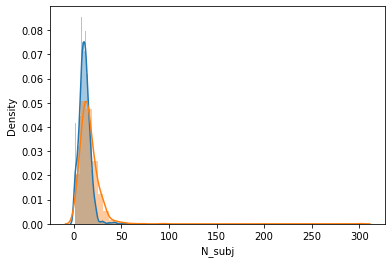

In [101]:
df_prior = prior_to_df_mlm(
    prior_bs, 
    ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd", "beta_pop", "beta_sd"],
    ["N_subj", "N_prime_subj", "beta_subj", "beta_r"]
)

sns.distplot(df_prior.N_prime_subj)
sns.distplot(df_prior.N_subj)

/Users/derekpowell/anaconda3/envs/bsampler/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='beta_subj', ylabel='Density'>

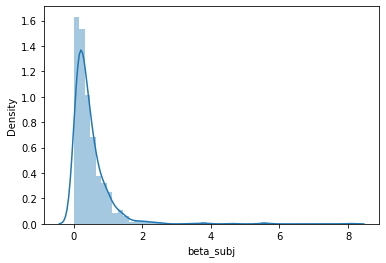

In [102]:
# sns.distplot( sigmoid(np.asarray(df_prior.beta_pop + df_prior.beta_sd * df_prior.beta_r))*10)
sns.distplot(df_prior.beta_subj)